In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns

In [2]:
df_1 = pd.read_csv('banknifty.csv')

In [3]:
df_1.head()

,index,date,time,open,high,low,close
0,BANKNIFTY,20121203,09:16,12125.70,12161.70,12125.70,12160.95
1,BANKNIFTY,20121203,09:17,12161.75,12164.80,12130.40,12130.40
2,BANKNIFTY,20121203,09:18,12126.85,12156.10,12126.85,12156.10
3,BANKNIFTY,20121203,09:19,12157.25,12164.75,12151.60,12164.20
4,BANKNIFTY,20121203,09:20,12162.80,12162.80,12148.20,12151.15


## Preprocessing Data

In [4]:
def Date_Time(dataFrame):
    dateTime = dataFrame['date'].map(str)+dataFrame['time']
    k = pd.to_datetime(dateTime, format='%Y%m%d%H:%M')
    dataFrame['DateTime'] = k
    
    dataFrame['Day'] = dataFrame['DateTime'].dt.day
    dataFrame['Month'] = dataFrame['DateTime'].dt.month
    dataFrame['Year'] = dataFrame['DateTime'].dt.year
    #dataFrame['Hour'] = dataFrame['DateTime'].dt.hour
    #dataFrame['Minute'] = dataFrame['DateTime'].dt.minute
    
    dataFrame = dataFrame.drop(labels=['DateTime'], axis=1)
    dataFrame['group']= dataFrame['Year'].map(str) + dataFrame['Month'].map(str)

    dataFrame = dataFrame[['open', 'high', 'low', 'Month', 'Year','group','close']]
    
    dataFrame= dataFrame.sort_values(by=['Year','Month'])
    dataFrame= dataFrame.reset_index(drop=True)
    
    return(dataFrame)

In [5]:
def processing(dataframe):
    df = dataframe
    
    month_group = df['group'].unique() # extract unique hour values to form group based on days, month and year
    m_group_index = np.arange(1,len(month_group)+1)# for reindexing hour group values from 1 to number of groups.
    #As indexing starts from 0 so 1 is added
    
    # replacing hour group values with new indexing for extracting hour groups
    #(This step will take 20 minutes due to 3 hundred thousand samples)
    # it is already done once and results are saved in file hour.npy
    # so instead of running again, load this file

    for i in range(len(month_group)):
        df['group'] = df['group'].replace([month_group[i]],m_group_index[i])

    df1 = pd.DataFrame(df, index= month_group) # this data frame has month group as index values for extracting its index
     
    count_index = df['close'].groupby(df['group']).count() # counting each month group values
    
    month_index = []  # extracting months index
    w=0
    for i in count_index:
        w = i+w
        month_index.append(w)
    month_index = np.array(month_index) -1 
    # above steps are adding count values(in other words "commulative count_index") 
    # we need commulative count_index as count_index are absolute values from which required values cant be extracted
    
    # extracting close values which is last value of each month group
    close = []
    for i in month_index:
        t = df.loc[i,'close']
        close.append(t)
    close = np.array(close)

    #extracting low, high, month, year values of each month group
    low = pd.DataFrame(df['low'].groupby(df['group']).min()).reset_index(drop=True)
    high = pd.DataFrame(df['high'].groupby(df['group']).max()).reset_index(drop=True)
    Month = pd.DataFrame(df['Month'].groupby(df['group']).max()).reset_index(drop=True)
    Year = pd.DataFrame(df['Year'].groupby(df['group']).max()).reset_index(drop=True)
    
    #extracting first value of open from each month group
    openn = []
    for i in (month_index-count_index+1):
        r = df.loc[i,'open']
        openn.append(r)
    openn = np.array(openn)
    
    #creating new data frame with extracted values 
    df2 = pd.DataFrame()
    
    df2['open'] = openn
    df2['high'] = high
    df2['low'] = low
    df2['Month'] = Month
    df2['Year'] = Year
    df2['close'] = close
    
    # rearranging data into ascending form
    df2 = df2.sort_values(by=['Year','Month'])
    df2 = df2.reset_index(drop=True) # reset index
    
    return(df2)

In [6]:
def scaling(dataFrame):
    
    close = np.array(dataFrame['close']).reshape(-1,1)
    stock_df = dataFrame.drop(labels=['close'], axis = 1)
    
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(stock_df)
    scaled_df = scaler.transform(stock_df)
    
    scaler2 = MinMaxScaler(feature_range=(0,1))
    scaler2.fit(close)
    scaled_close = scaler2.transform(close)
    
    scaled_df = pd.DataFrame(scaled_df, columns=stock_df.columns)
    scaled_df['close'] = scaled_close
    
    return(scaled_df, scaler, scaler2)

In [7]:
stock_df1 = Date_Time(df_1)

In [8]:
stock_df1.head()

,open,high,low,Month,Year,group,close
0,11276.55,11276.55,11265.80,11,2012,201211,11268.90
1,11267.95,11267.95,11258.85,11,2012,201211,11260.05
2,11259.45,11259.45,11243.90,11,2012,201211,11243.90
3,11246.50,11246.60,11237.90,11,2012,201211,11238.90
4,11241.15,11247.20,11239.30,11,2012,201211,11245.30


In [9]:
stock_df1_1 = processing(stock_df1)

In [10]:
stock_df1_1.head()

,open,high,low,Month,Year,close
0,11276.55,12175.30,11230.20,11,2012,12153.10
1,12125.70,12571.60,12053.45,12,2012,12474.25
2,12547.15,12960.65,12509.45,1,2013,12702.75
3,12719.85,12743.20,11401.20,2,2013,11563.95
4,11544.70,12241.30,11048.40,3,2013,11401.70


In [11]:
stock_df2, in_scaler, out_scaler = scaling(stock_df1_1)

In [12]:
stock_df2.head()

,open,high,low,Month,Year,close
0,0.198965,0.182982,0.556551,0.909091,0.00,0.286585
1,0.277093,0.220061,0.603182,1.000000,0.00,0.316408
2,0.315869,0.256462,0.629011,0.000000,0.25,0.337627
3,0.331758,0.236116,0.566237,0.090909,0.25,0.231876
4,0.223637,0.189157,0.546253,0.181818,0.25,0.216809


## Data Plots

#### Time Series Distribution For Month

Text(0, 0.5, 'Stock Rate')

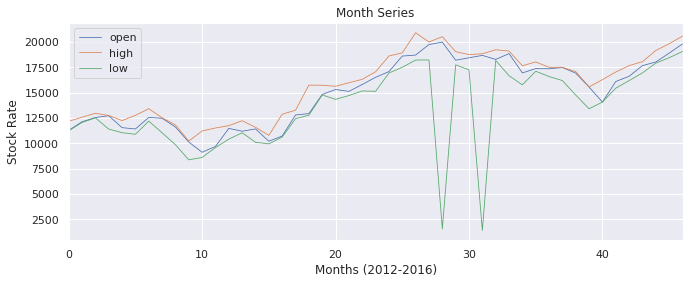

In [13]:
sns.set(rc={'figure.figsize':(11,4)})
stock_df1_1[['open','high','low']].plot(linewidth=0.8, title='Month Series')
plt.xlabel('Months (2012-2016)')
plt.ylabel('Stock Rate')

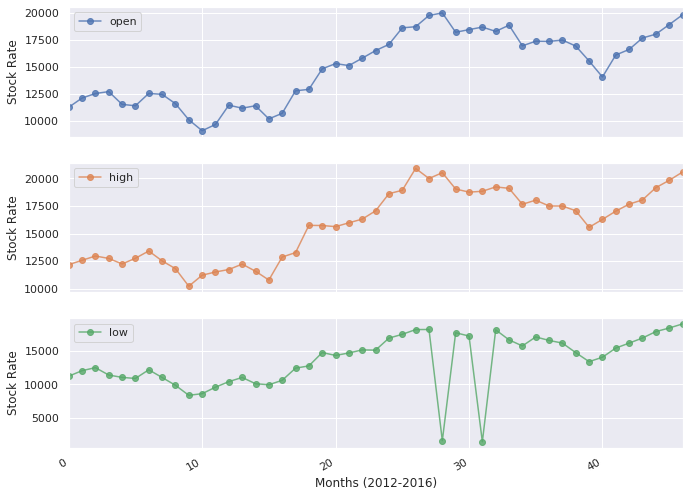

In [14]:
cols_plot = ['open', 'high','low']
axes = stock_df1_1[cols_plot].plot(marker='o', alpha=0.8, linestyle='-', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Stock Rate')
    ax.set_xlabel('Months (2012-2016)')

#### Box Pots

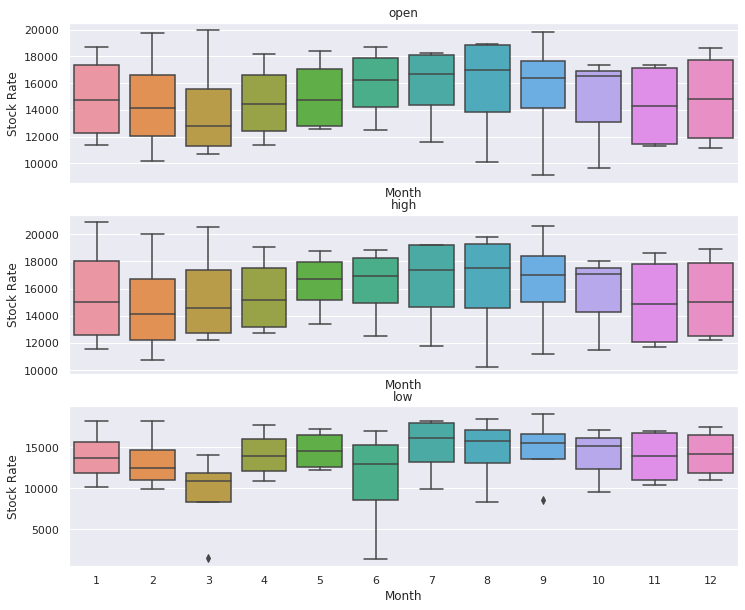

In [15]:
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
for name, ax in zip(['open', 'high', 'low'], axes):
    sns.boxplot(data=stock_df1_1, x='Month', y=name, ax=ax)
    ax.set_ylabel('Stock Rate')
    ax.set_title(name)

#### Heat Map

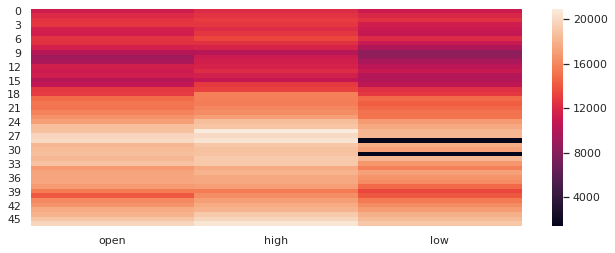

In [16]:
sns.heatmap(stock_df1_1[['open','high','low']])

#### Histograms and Curve Distribution

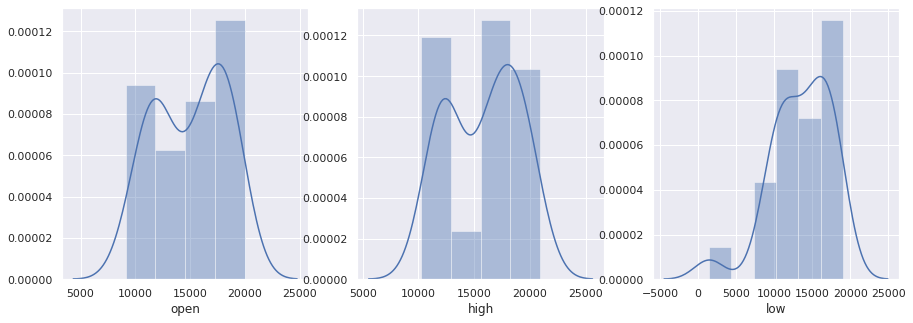

In [17]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
for name, ax in zip(['open', 'high', 'low'], axes):
    sns.distplot(stock_df1_1[name], ax=ax)

#### Correlation

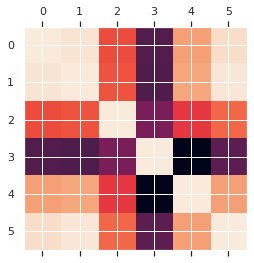

In [18]:
plt.matshow(stock_df1_1.corr())
plt.show()

#### Scatter Plot

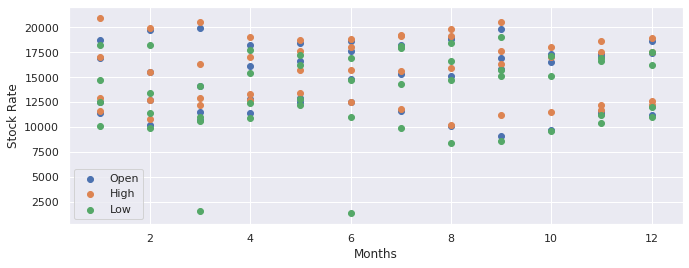

In [19]:
plt.scatter(stock_df1_1['Month'],stock_df1_1['open'])
plt.scatter(stock_df1_1['Month'],stock_df1_1['high'])
plt.scatter(stock_df1_1['Month'],stock_df1_1['low'])
plt.legend(['Open','High','Low'])
plt.xlabel('Months')
plt.ylabel('Stock Rate')
plt.show()

#### Trend Curve

Text(0.5, 0, 'Months')

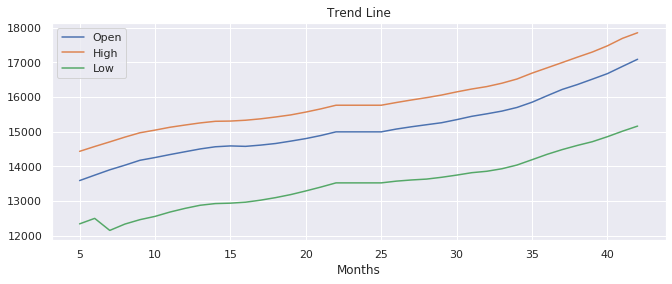

In [20]:
plt.plot(stock_df1_1['open'].rolling(window=50, center=True, min_periods=30).mean())
plt.plot(stock_df1_1['high'].rolling(window=50, center=True, min_periods=30).mean())
plt.plot(stock_df1_1['low'].rolling(window=50, center=True, min_periods=30).mean())
plt.legend(['Open','High','Low'])
plt.title('Trend Line')
plt.xlabel('Months')

## Splitting Data into Train/Test

In [14]:
def train_test_data(data):
    x = np.array(data.iloc[:,:-1])
    y = np.array(data.iloc[:,-1])
    
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, shuffle= True)
    
    return (x_train, x_test, y_train, y_test)

In [15]:
x_train_df1, x_test_df1, y_train_df1, y_test_df1 = train_test_data(stock_df2)

In [16]:
x_train_df1.shape

(37, 5)

In [17]:
y_train_df1.shape

(37,)

In [18]:
X_train_df1 = x_train_df1.reshape((x_train_df1.shape[0],1, x_train_df1.shape[1]))
X_test_df1 = x_test_df1.reshape((x_test_df1.shape[0],1, x_test_df1.shape[1]))

# Convolution Neural Network

In [19]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation, Conv1D, Flatten, MaxPooling1D

Using TensorFlow backend.


In [37]:
model = Sequential()
model.add(Conv1D(filters=8, kernel_size=3, activation='relu', padding = 'same',
                 input_shape=(X_train_df1.shape[1],X_train_df1.shape[2])))
model.add(MaxPooling1D(pool_size=2, padding='same'))
model.add(Flatten())
model.add(Dense(4))
model.add(Activation('relu'))
#model.add(Dense(4))
#model.add(Activation('relu'))
model.add(Dense(y_train_df1.reshape(-1,1).shape[1]))

model.compile(loss='mae', optimizer='adam', metrics=['mean_squared_error'])

In [38]:
model.fit(X_train_df1, y_train_df1, epochs =20, verbose=1, batch_size=2,
          validation_data=(X_test_df1,y_test_df1), shuffle=True)

Train on 37 samples, validate on 10 samples
Epoch 1/20
37/37 [==============================] - 0s 12ms/step - loss: 0.3305 - mean_squared_error: 0.1525 - val_loss: 0.2278 - val_mean_squared_error: 0.0615
Epoch 2/20
37/37 [==============================] - 0s 3ms/step - loss: 0.1918 - mean_squared_error: 0.0573 - val_loss: 0.1342 - val_mean_squared_error: 0.0332
Epoch 3/20
37/37 [==============================] - 0s 5ms/step - loss: 0.1412 - mean_squared_error: 0.0317 - val_loss: 0.1298 - val_mean_squared_error: 0.0330
Epoch 4/20
37/37 [==============================] - 0s 5ms/step - loss: 0.1219 - mean_squared_error: 0.0245 - val_loss: 0.1152 - val_mean_squared_error: 0.0230
Epoch 5/20
37/37 [==============================] - 0s 5ms/step - loss: 0.1135 - mean_squared_error: 0.0204 - val_loss: 0.1046 - val_mean_squared_error: 0.0193
Epoch 6/20
37/37 [==============================] - 0s 5ms/step - loss: 0.1007 - mean_squared_error: 0.0169 - val_loss: 0.0916 - val_mean_squared_error: 0.

In [39]:
predict = model.predict(X_test_df1)

In [40]:
# Output value is scaled. To get actual value undo scaled value of output
print('Scaled Value Predicted: %.2f' %predict[2])
print('Actual Predicted Value: %.2f'%out_scaler.inverse_transform([predict[2]]))
print('True Value: %.2f' %out_scaler.inverse_transform([[y_test_df1[2]]]))

Scaled Value Predicted: 0.36
Actual Predicted Value: 12984.23
True Value: 12900.90


In [24]:
model.save('model.h5')

### Evaluation

In [41]:
print('R_2 Score: %.7f' %r2_score(y_test_df1, predict))
print('Mean Absolute Error: %.7f' %mean_absolute_error(y_test_df1, predict))
print('Mean Square Error: %.7f' %mean_squared_error(y_test_df1, predict))
print('Root Mean Square Error: %.7f' %np.sqrt(mean_squared_error(y_test_df1, predict)))

R_2 Score: 0.9182536
Mean Absolute Error: 0.0767409
Mean Square Error: 0.0075178
Root Mean Square Error: 0.0867052


### Plots

/home/kirmani/anaconda3/envs/env1/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':
/home/kirmani/anaconda3/envs/env1/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


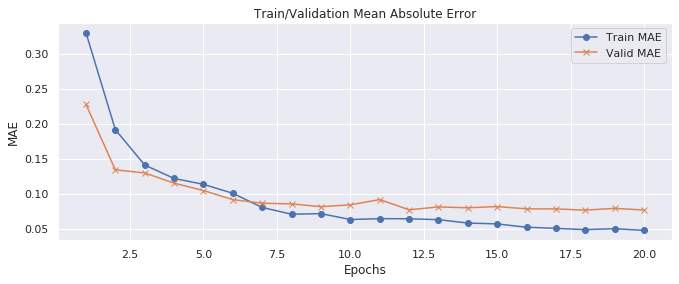

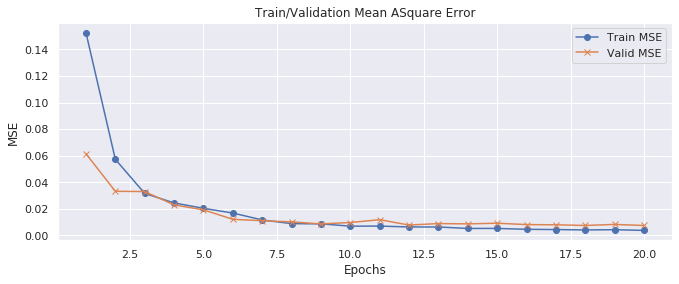

In [42]:
f, ax = plt.subplots()
ax.plot([None] + model.history.history['loss'], 'o-' )
ax.plot([None] + model.history.history['val_loss'], 'x-')

ax.legend(['Train MAE', 'Valid MAE'], loc=1)
ax.set_title('Train/Validation Mean Absolute Error')
ax.set_xlabel('Epochs')
ax.set_ylabel('MAE')
f.show()

f, ax = plt.subplots()
ax.plot([None] + model.history.history['mean_squared_error'], 'o-' )
ax.plot([None] + model.history.history['val_mean_squared_error'], 'x-')

ax.legend(['Train MSE', 'Valid MSE'], loc=1)
ax.set_title('Train/Validation Mean ASquare Error')
ax.set_xlabel('Epochs')
ax.set_ylabel('MSE')
f.show()

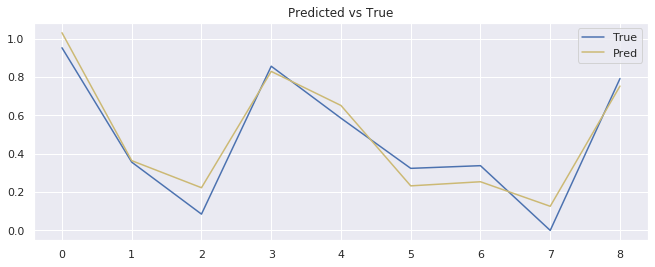

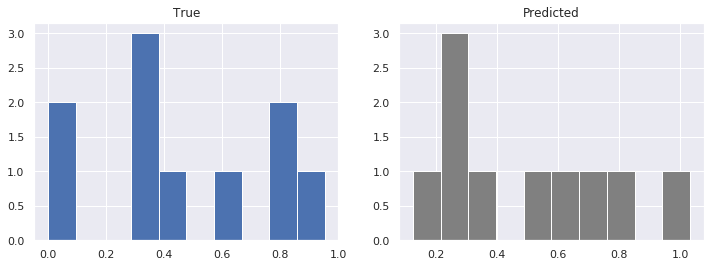

In [43]:
plt.plot(y_test_df1[1:10000], 'b')
plt.plot( predict[1:10000], 'y')
plt.legend(['True', 'Pred'])
plt.title('Predicted vs True')
plt.show()

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(y_test_df1)
plt.title('True')

plt.subplot(1,2,2)
plt.hist(predict, color='grey')
plt.title('Predicted')
plt.show()

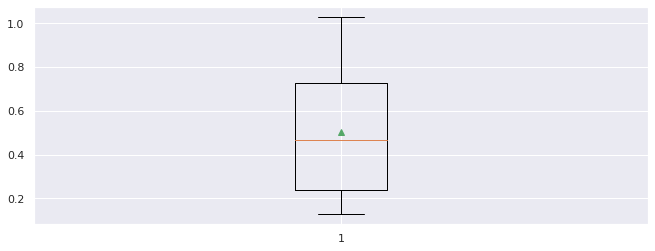

In [44]:
plt.boxplot(predict, showmeans=True)
plt.show()

## Time Based Prediction Plot

In [45]:
true = out_scaler.inverse_transform([y_test_df1]) # true values without scaling
result = out_scaler.inverse_transform(predict)  # predicted values without scaling

In [46]:
tm = in_scaler.inverse_transform(x_test_df1)  # descaling test input values

In [47]:
tm1 = tm[:,3]   # descaling Test set month values
tm2 = tm[:,4]   # descaling Test set Year values

In [48]:
# Result DataFrame without scaled values for true and predicted
res = pd.DataFrame()
res['Month'] = tm1.astype(int)
res['Year'] = tm2.astype(int)
res['True'] = np.squeeze(true)
res['Predicted'] = np.squeeze(result)
res['Time'] = res['Month'].map(str) +'-' + res['Year'].map(str)

In [49]:
# Sorting result values according to time in ascending order and resetting index
res1 = res.sort_values(by=['Year','Month'])
res1 = res1.reset_index(drop=True)

In [50]:
res1.head()

,Month,Year,True,Predicted,Time
0,1,2013,12702.75,11799.885742,1-2013
1,4,2013,12551.95,11569.356445,4-2013
2,7,2013,9982.05,11464.077148,7-2013
3,8,2013,9066.95,10421.660156,8-2013
4,4,2014,12900.90,12984.230469,4-2014


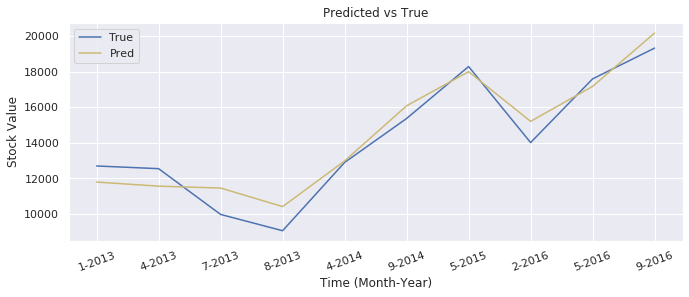

In [51]:
plt.plot(res1['True'], 'b')
plt.plot( res1['Predicted'], 'y')
plt.legend(['True', 'Pred'])
plt.title('Predicted vs True')
plt.xticks(ticks=np.arange(len(res1)), labels=res1['Time'], rotation = 20)
plt.ylabel('Stock Value')
plt.xlabel('Time (Month-Year)')
plt.show()


## User Input Data

In [93]:
def user():
    u = input('Do you want to enter custom data sample? Enter "y" or "n" :')
    if u == 'y':
        print('\nStock value range is 1400-21000')
        openn = float(input('Enter Opening Stock Value of the day: '))
        high = float(input('Enter Highest Stock Value of the day: '))
        low = float(input('Enter Lowest Stock Value of the day: '))
        date = str(input('Enter Date and time in format (21/03/201914:02) : '))
        
        new_data = np.array([[openn, high, low, date]])
    else:
        new_data = None
    
    
                       
    return new_data

In [94]:
def u_output(u_dt):
    user_df = pd.DataFrame(u_dt, columns=['Open','High', 'Low', 'Date'])
    user_dt = pd.to_datetime(user_df['Date'], format='%d/%m/%Y%H:%M')
    
    user_df2 = user_df.drop(labels=['Date'], axis=1)    

    user_df2['Month'] = user_dt.dt.month
    user_df2['Year'] = user_dt.dt.year
      
    sca_user_df1 = in_scaler.transform(user_df2)

    user_df1 = pd.DataFrame(sca_user_df1, columns=user_df2.columns)
    
    u_pred = model.predict(np.array(user_df1).reshape(user_df1.shape[0],1,user_df1.shape[1]))
    u_real1 = out_scaler.inverse_transform(u_pred) 
    
    return(u_real1)

In [96]:
user_data = user()

Do you want to enter custom data sample? Enter "y" or "n" :y

Stock value range is 1400-21000
Enter Opening Stock Value of the day: 3000
Enter Highest Stock Value of the day: 18976
Enter Lowest Stock Value of the day: 13456
Enter Date and time in format (21/03/201914:02) : 24/08/201513:09


In [97]:
if user_data is None:
    print('Process Completed')
else:
    o1 = u_output(user_data)
    print('Stock Closing is at: %.2f'%o1)

Stock Closing is at: 16054.17
